# SD212: Graph mining
## Lab 2: Graph structure

In this lab, you will learn to:
* plot the degree distribution and observe the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions),
* estimate the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph and observe the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
* estimate the [clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient) of a graph.

In [1]:
!pip install scikit-network

     |████████████████████████████████| 2.3MB 3.0MB/s 


## Import

In [2]:
import numpy as np
from scipy import sparse
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [6]:
from sknetwork.data import load_netset, cyclic_graph, linear_graph
from sknetwork.utils import bipartite2undirected

## Data

We will work on the following graphs (see the [NetSets](https://graphs.telecom-paristech.fr/Home_page.html#netsets-section) collection for details):
* Openflights (graph)
* WikiVitals (digraph)
* Cinema (bigraph)

In [7]:
openflights = load_netset('openflights')

In [8]:
# focus on degrees, not weights
adjacency = (openflights.adjacency > 0)

In [9]:
wikivitals = load_netset('wikivitals')

In [10]:
cinema = load_netset('cinema')

## 1. Power law

We first focus on the power law degree distribution.

We consider the empirical distributions of:
* degrees in the Openflights graph,
* out-degrees and in-degrees in the WikiVitals graph.

## To do

For each of these distributions:
* Compute the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) and compare it to that of a Poisson distribution with the same mean.
* Plot the [tail distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)) in log-log scale and compare it to that of an equivalent [Erdos-Rényi](https://en.wikipedia.org/wiki/Erdős–Rényi_model) graph (same number of nodes, same average degree).
* Conclude: do you consider that this is a power law?

**Hint:** Use the ``loglog`` function of ``pyplot``.

In [11]:
#degre de chaque noeuds
n=adjacency.shape[0]
degrees=np.zeros(n)
for i in range(n):
    degrees[i]=adjacency.indptr[i+1]-adjacency.indptr[i]   
m=degrees.mean()
sig=degrees.std()
cv=sig/m
print("cv =",cv)
print("moyenne =",m)

cv_poiss=np.sqrt(m)
print("cv_poiss =",cv_poiss)

cv = 2.1143999842457535
moyenne = 11.748789150791088
cv_poiss = 3.4276506751404945


In [15]:
#d+
adjacency2 = (wikivitals.adjacency > 0)
wiki_degree = np.dot(adjacency2.toarray(),np.ones(len(wikivitals.names)))
print(wiki_degree)
wiki_mean = np.mean(wiki_degree)
wiki_std = np.std(wiki_degree)
print(wiki_std/wiki_mean)
print(1/np.sqrt(wiki_mean))

[147. 143. 173. ...  22.  65.  63.]
0.8065909718992998
0.11242758479380567


In [16]:
#d-
adjacency3 = (wikivitals.adjacency > 0)
wiki_degree = np.dot(adjacency3.toarray().T,np.ones(len(wikivitals.names)))
print(wiki_degree)
wiki_mean = np.mean(wiki_degree)
wiki_std = np.std(wiki_degree)
print(wiki_std/wiki_mean)
print(1/np.sqrt(wiki_mean))

[ 36. 147. 190. ...  20.  68.  22.]
1.3553811414388752
0.11242758479380567


Text(0.5, 1.0, 'Distribution of the degrees')

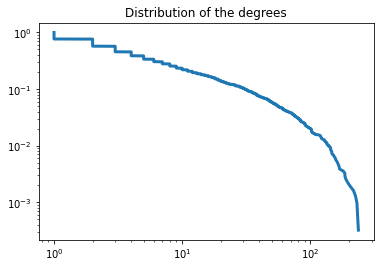

In [ ]:
plt.loglog(np.sort(degrees),1-np.arange(n)/n,lw=3)
plt.title("Distribution of the degrees")

In [ ]:
adjacency.dot(np.ones(n))

array([4., 7., 8., ..., 1., 1., 1.])

## 2. Small-world

You will now make a few experiments highlighting the small-world property.

## To do

* Complete the following function computing the distances from any given node in number of hops.
* Compare it to the function `shortest_path` of SciPy on WikiVitals.

In [ ]:
""""def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    # vector of nodes reached after t steps
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    change = True
    t = 0
    while change:
        t += 1
        # to be modified
        indexes=[]
        for i in range(n):
            if reached[i]==True:
            #si le noeud i a déjà été atteint
                deb=adjacency.indptr[i]
                fin=adjacency.indptr[i+1]
                for j in range(deb,fin):
                #alors je regarde tous les noeuds qu'il va atteindre
                    indexes.append(adjacency.indices[j])
        indexes=np.array(indexes)
        indexes=np.unique(indexes)
        reached[indexes]=True                       
        # end 
        new_nodes = np.argwhere((distances == np.inf) * reached).ravel()
        distances[new_nodes] = t
        change = len(new_nodes)
    return distances
"""

'"def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:\n    \'\'\'Get distances from a source node in number of hops.\n    \n    Parameters\n    ----------\n    adjacency: \n        Adjacency matrix of the graph.\n    source:\n        Source node\n    \n    Returns\n    -------\n    distances:\n        Vector of distances.\n    \'\'\'\n    n = adjacency.shape[0]\n    distances = np.inf * np.ones(n)\n    distances[source] = 0\n    # vector of nodes reached after t steps\n    reached = np.zeros(n).astype(bool)\n    reached[source] = True\n    change = True\n    t = 0\n    while change:\n        t += 1\n        # to be modified\n        indexes=[]\n        for i in range(n):\n            if reached[i]==True:\n            #si le noeud i a déjà été atteint\n                deb=adjacency.indptr[i]\n                fin=adjacency.indptr[i+1]\n                for j in range(deb,fin):\n                #alors je regarde tous les noeuds qu\'il va atteindre\n                 

In [ ]:
def get_distances(adjacency: sparse.csr_matrix, source: int) -> np.ndarray:
    '''Get distances from a source node in number of hops.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    source:
        Source node
    
    Returns
    -------
    distances:
        Vector of distances.
    '''
    n = adjacency.shape[0]
    distances = np.inf * np.ones(n)
    distances[source] = 0
    # vector of nodes reached after t steps
    reached = np.zeros(n).astype(bool)
    reached[source] = True
    change = True
    t = 0
    while change:
        t += 1
        # to be modified
        reached=adjacency.T.dot(reached)                      
        # end 
        new_nodes = np.argwhere((distances == np.inf) * reached).ravel()
        distances[new_nodes] = t
        change = len(new_nodes)
    return distances

In [ ]:
distances=get_distances(adjacency,0)

In [ ]:
distances_scipy=shortest_path(adjacency)[0]

In [ ]:
distances

array([0., 1., 1., ..., 5., 5., 5.])

In [ ]:
distances_scipy

array([0., 1., 1., ..., 5., 5., 5.])

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?

In [ ]:
ind=np.where(openflights.names=='Charles de Gaulle International Airport')[0][0]
print(ind)
l=shortest_path(adjacency)
l=l[ind]

622


In [ ]:
n=adjacency.shape[0]
for i in range(1,4):
    print(str(100*len(l[l<=i])/n)+"% of the airports can be reached in "+str(i)+" flights")

7.5556990636099455% of the airports can be reached in 1 flights
61.89861155957378% of the airports can be reached in 2 flights
90.89441394898289% of the airports can be reached in 3 flights


* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

In [ ]:
wikivitals.names

array(['The arts', 'Art', 'Architecture', ..., 'Baby transport',
       'Pipeline transport', 'Tractor'], dtype='<U62')

In [ ]:
ind=np.where(wikivitals.names=='Paris')[0][0]
ind

3279

In [ ]:
adjacency_wiki=wikivitals.adjacency
l=shortest_path(adjacency_wiki)
l=l[ind]

In [ ]:
adjacency_wiki=wikivitals.adjacency

In [ ]:
n=adjacency_wiki.shape[0]
for i in range(1,4):
    print(str(100*len(l[l<=i])/n)+"% of the articles can be reached in "+str(i)+" cliks")

3.555733120255693% of the articles can be reached in 1 cliks
64.80223731522173% of the articles can be reached in 2 cliks
99.31082700759089% of the articles can be reached in 3 cliks


## To do

* Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
* Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?

## To do

The following function estimates the [diameter](https://en.wikipedia.org/wiki/Distance_(graph_theory)) of a graph.

* Adapt this function so that it returns a path of length equal to this estimated diameter.
* Give a path of **length at least 10** in Openflights (with the names of the airports).
* Give a path of **length at least 5** in WikiVitals (with the names of the articles).

In [ ]:
def estimate_diameter(adjacency: sparse.csr_matrix, n_samples=100) -> int:
    '''Estimate the diameter of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    n_samples:
        Number of samples.
    
    Returns
    -------
    diameter:
        Estimation of the diameter. 
    '''    
    n = adjacency.shape[0]
    #je prends des noeuds au hasard
    nodes = np.random.choice(n, size=n_samples)
    #je regarde leur liste de distance
    distances = shortest_path(adjacency.T, indices=nodes)
    #je prends la distance max
    sources = np.where(np.isinf(distances), -1, distances).argmax(axis=1)
    #à partir de ces nouveux noeuds je regarde le max de leur tableau de distance
    distances , preds = shortest_path(adjacency, indices=sources, return_predecessors=True)
    #je peux estimer le diamètre avec cela
    diameter = np.where(np.isinf(distances), -1, distances).max()
    
    #maintenant, je veux un chemin avec ce diamètre
    #je prends le noeud correspondant au max dans distance
    k = np.where(np.isinf(distances), -1, distances).max(axis=1).argmax()
    #je prends une source bien choisie
    source = sources[k]
    pred = preds[k]
    distance = distances[k]
    #je prends la destination la plus loin de la source
    dest = np.where(np.isinf(distance), -1, distance).argmax()
    path = []
    #je construit le chemin petit à petit
    while dest != source:
        path.append(dest)
        dest = pred[dest]   
    return int(diameter),path

In [ ]:
diameter , path = estimate_diameter(adjacency_wiki)

* Give a path of **length at least 5** in WikiVitals (with the names of the articles).

In [ ]:
wikivitals.names[path]

array(['Night (book)', 'Elie Wiesel',
       'International Atomic Energy Agency', 'Poland', 'Jurassic',
       'Perciformes'], dtype='<U62')

In [ ]:
diameter , path = estimate_diameter(adjacency)

* Give a path of **length at least 10** in Openflights (with the names of the airports).

In [ ]:
openflights.names[path]

array(['Thule Air Base', 'Qaanaaq Airport', 'Upernavik Airport',
       'Ilulissat Airport', 'Godthaab / Nuuk Airport',
       'Keflavik International Airport',
       'Lester B. Pearson International Airport',
       'Timmins/Victor M. Power', 'Moosonee Airport',
       'Fort Albany Airport', 'Kashechewan Airport',
       'Attawapiskat Airport'], dtype='<U65')

## To do

* Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors.
* Plot the corresponding histogram.

**Hint:** Use distances in the bipartite graph. Do **not** try to compute the co-starring graph of actors, with adjacency matrix $A = B^TB$ where $B$ is the movie-actor biadjacency matrix (guess why).

In [ ]:
cinema

{'biadjacency': <88440x44586 sparse matrix of type '<class 'numpy.bool_'>'
 	with 304006 stored elements in Compressed Sparse Row format>,
 'names_col': array(['Joe E. Brown', 'Eric Blore', 'Susan Hayward', ...,
        'Olivier Saladin', 'Reona Hirota', 'Leyla Sayar'], dtype='<U95'),
 'names_row': array(['$1,000 a Touchdown', '$9.99', '$', ...,
        'Šta se zgodi kad se ljubav rodi', 'Želary', '’O Re'], dtype='<U95')}

In [ ]:
biadjacency=cinema.biadjacency
# corresponding graph with a mix of movies and actors (movies first)
adjacency = bipartite2undirected(biadjacency)
n=len(cinema.names_col)
m=len(cinema.names_row)
ind2=np.where(cinema.names_col=='Marion Cotillard')[0][0]
ind1=np.where(cinema.names_col=='Kevin Bacon')[0][0]
distances=shortest_path(adjacency,indices=[m+ind1])
print("La distance à Marion Cotillard est",distances[0][m+ind2]/2)

La distance à Marion Cotillard est 2.0


In [ ]:
distances_actors=distances[0][m:]/2

In [ ]:
distances_actors

array([3., 3., 2., ..., 3., 3., 7.])

Text(0.5, 1.0, 'Bacon numbers')

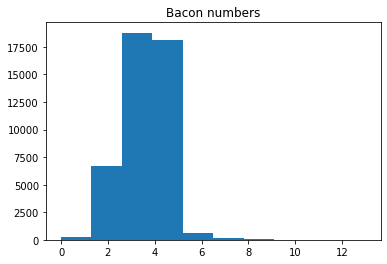

In [ ]:
plt.hist(distances_actors)
plt.title("Bacon numbers")

## 3. Clustering coefficient

You will now learn to estimate the clustering coefficient of a graph.

## To do


* Complete the following function to estimate the clustering coefficient of a graph.
* Test it on a triangle and  a line.
* Compute the clustering coefficient of Openflights and WikiVitals (seen as an undirected graph).

**Hint:** A triangle is... a cycle of length 3

In [17]:
def clustering_coefficient(adjacency: sparse.csr_matrix, n_samples: int = 500) -> float:
    '''Get the clustering coefficient of a graph.
    
    Parameters
    ----------
    adjacency: 
        Adjacency matrix of the graph.
    
    Returns
    -------
    clustering_coef:
        Clustering coefficient.
    '''
    oui=0
    non=0
    
    n = adjacency.shape[0]
    if n_samples < n:
        nodes = np.random.choice(n, size=n_samples, replace=False)
    else:
        nodes = np.arange(n)

    # to be modified
    distances = shortest_path(adjacency)
    for n in nodes:
        distance = distances[n]
        voisins = np.argwhere(distance==1)
        #print(voisins)
        for voisin1 in voisins:
            distance_voisin1 = distances[voisin1[0]]
            for voisin2 in voisins:
                if voisin2 != voisin1:
                    if distance_voisin1[voisin2[0]]==1:
                        oui+=1
                    else:
                        non+=1
    # a single loop on preselected nodes allowed
    clustering_coef = float(oui)/(oui+non)
    
    return clustering_coef

In [18]:
triangle = cyclic_graph(3)

In [19]:
line = linear_graph(5)

In [21]:
clustering_coefficient(triangle)

1.0

In [22]:
from sknetwork.data import karate_club, load_netset
from sknetwork.visualization import svg_graph

In [23]:
graph = karate_club(metadata=True)
adjacency = graph.adjacency
position = graph.position
labels = graph.labels

In [24]:
clustering_coefficient(adjacency)

0.2556818181818182

In [ ]:
clustering_coefficient(adjacency_wiki)

0.2249761747112695

In [ ]:
adjacency = openflights.adjacency

In [ ]:
clustering_coefficient(adjacency)

0.17174678994537587